# Activity Coefficients in Electrolyte Solutions
_Max Hebditch and Mikael Lund, August 2016_

In this notebook we estimate activity coefficients, $\gamma$, of salts in aqueous solution using Grand Canonical Metropolis Monte Carlo simulations. The particles are modelled as charged Lennard-Jones particles immersed in a dielectric continuum. By varying particle radii, experimentally obtained values are matched for 1:1 and 1:3 salts:

ion       | valency | radius (Å)
----------| ------- | ------------
sodium    | +1      | 2.3
chloride  | -1      | 2.3
citrate   | -3      | 3.5

Note that the above values are for a combined Lennard-Jones/Coulomb potential and cannot be directly compared with previously radii fitted for the primitive model of electrolytes (hard spheres + Coulomb). See bottom of the page for more details.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
from math import sqrt, pi, exp
import os.path, os, sys, json
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir
print(workdir)

/Users/mikael/github/faunus-notebooks/activity-coefficients


### Download and compile the MC software

This will download the free Monte Carlo software _Faunus_; check out the version we used; and compile it (C++ compiler and CMake required)

In [2]:
%%bash -s "$workdir"
%cd -q $1

echo 'fau_example(excess "./" excess.cpp)' > mc/CMakeLists.txt

if [ ! -d "faunus/" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    git checkout 78e8887749786510f09d265f5ef2651a143a39ce
else
    cd faunus
fi

cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on -DMYPLAYGROUND=$1/mc &>/dev/null
make excess -j4
%cd $1

[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
[100%] Built target excess


bash: line 1: fg: no job control
bash: line 15: fg: no job control


### Simulation setup
Wall time, number of cores etc. Currently for the slurm system.

In [3]:
# definition of salts (n=stoichiometry; z=valency; r=radius; L=box length; activities in mol/l)
salts = pd.Series(
    {
        'NaCl' : pd.Series(
            dict(ion1='Na', ion2='Cl', n1=1, n2=1, z1=1, z2=-1, r1=2.2, r2=2.2, L=50,
                 activities=np.arange(0.1,1.6,0.05), exp='exp-nacl-coeff.csv',
                 color='red', label=u'NaCl' ) ),
        'Na3Cit' : pd.Series(
            dict(ion1='Na', ion2='Cit', n1=3, n2=1, z1=1, z2=-3, r1=2.3, r2=3.5, L=100,
                 activities=np.arange(0.005,0.1,0.005), exp='exp-na3cit-coeff.csv',
                 color='blue', label=u'Na$_3$(C$_6$H$_5$O$_7$)' ) )
    }
)

In [4]:
%cd -q $workdir

def mkinput():
    js = {
            "moleculelist": {
                "salt": { "Ninit": 20, "atomic": True, "atoms": d.n1*(d.ion1+' ') + d.n2*(d.ion2+' ') }
            }, 
            "energy": {
                "nonbonded": { "coulomb": { "epsr": 80 } }
            }, 
            "moves": {
                "atomtranslate": { "salt": { "permol": True, "prob": 0.01 } }, 
                "atomgc": { "molecule": "salt" }
            }, 
            "system": {
                "mcloop"      : { "macro": 10, "micro": micro }, 
                "cuboid"      : { "len": d.L },
                "coulomb"     : { "epsr": 80 },
                "temperature" : 298.15
            }, 
            "atomlist": {
                d.ion1: { "q": d.z1, "r": d.r1, "eps":0.01, "dp": 50, "activity": d.n1*activity }, 
                d.ion2: { "q": d.z2, "r": d.r2, "eps":0.01, "dp": 50, "activity": d.n2*activity }
            }
    }

    with open('excess.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

# flow control:
equilibration = True   # if true, delete state file and start over
production    = True   # if true, start from present state file
override      = False  # if true, override existing files

for salt, d in salts.iteritems():
    for activity in d.activities:
        
        pfx=salt+'-a'+str(activity)
        if not os.path.isdir(pfx):
            %mkdir -p $pfx
        else:
            if override==False:
                break
        %cd $pfx

        # equilibration run
        if equilibration:
            !rm -fR state
            micro=5000
            mkinput()
            !../mc/excess > eq 2>&1
            !rm -fR analysis_out.json

        # production run
        if production:
            micro=50000
            mkinput()
            !../mc/excess > out 2>&1

        %cd -q ..

print('done.')

done.


### Analysis

The simulation output of the Grand Canonical move statistics contain information about the excess chemical potential and is stored in the file `move_out.json`. In the following we read this data and store it in a Pandas object.

In [5]:
%cd -q $workdir
import json

for salt, d in salts.items():
    d['g1'] = []
    d['g2'] = []
    for activity in d.activities:
        pfx=salt+'-a'+str(activity)

        if os.path.isdir(pfx):
            %cd -q $pfx
            r = json.load( open('move_out.json') )['moves']['moves/atomgc']['atoms']
            d['g1'].append( r[d.ion1]['gamma'] )
            d['g2'].append( r[d.ion2]['gamma'] )
            %cd -q ..
salts.NaCl

L                                                            50
activities    [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0...
color                                                       red
exp                                          exp-nacl-coeff.csv
ion1                                                         Na
ion2                                                         Cl
label                                                      NaCl
n1                                                            1
n2                                                            1
r1                                                          2.2
r2                                                          2.2
z1                                                            1
z2                                                           -1
g1            [0.759159168158639, 0.724636620882271, 0.70350...
g2            [0.759159168158639, 0.724636620882271, 0.70350...
dtype: object

### Plot mean activity coefficients

For compound $M_pX_q$, the mean ionic activity coefficient is $ \gamma_{\pm} = \sqrt[q+p]{ \gamma_M^p \gamma_X^q}$. Note that the experimental data is in _molality_, i.e. moles salt per kilo solvent and should in principle be converted to the molarity scale as outlined in i.e. Robinson and Stokes classic book. We ignore this here as the intended use for the model is for sub-molar concentrations. All salt concentrations are converted to the ionic strength, $I=\frac{1}{2}\sum c_i z_i^2$ where $c$ are molar concentrations, $z$ valencies.

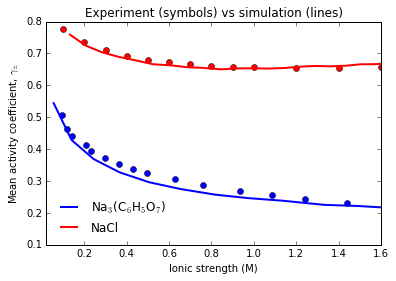

In [6]:
%cd -q $workdir
def ionicstrength(c, n1, n2, z1, z2):
    return 0.5*( n1*c*z1**2 + n2*c*z2**2 )

def meanactivity(gA, gB, p, q):
    ''' mean ionic activity coefficient'''
    return ( gA**p * gB**q ) ** (1.0/(p+q))

for salt, d in salts.iteritems():
    # experiment
    C, g = np.loadtxt(d.exp, delimiter=',', skiprows=1, unpack=True)
    I = ionicstrength( C, d.n1, d.n2, d.z1, d.z2)
    plt.plot(I, g, marker='o', ls='none', color=d.color)
    
    # simulation
    g = meanactivity( np.array(d.g1), np.array(d.g2), d.n1, d.n2 )
    C = d.activities / g # molarity
    I = ionicstrength(C, d.n1, d.n2, d.z1, d.z2)
    
    plt.plot( I, g, label=d.label, lw=2, color=d.color)

plt.legend(loc=0, frameon=False)
plt.ylabel('Mean activity coefficient, $\gamma_{\pm}$')
plt.xlabel('Ionic strength (M)')
plt.xlim((0.02,1.6))
plt.title('Experiment (symbols) vs simulation (lines)')
print('')

### Pair potential between ions

The MC simulation uses a pair potential that is a mix of Lennard-Jones plus a Coulomb interaction with a high dielectric background. The particle radii are therefore _not_ just the normal interpretation as in LJ as is illustrated for the distance of closest approach between a cation and anion below.

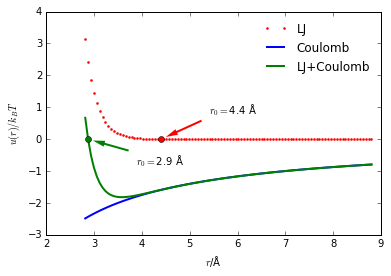

In [7]:
from scipy.optimize import newton

lB=7           # Bjerrum length for water (Å)
s=2*2.2        # sigma (Å)
eps=0.01 / 2.5 # epsilon (kT)
r = np.linspace(0.64*s, 2*s, 100)

def el(r): return -lB/r                        # Coulomb pot.
def lj(r): return 4*eps*( (s/r)**12-(s/r)**6 ) # Lennard-Jones pot.
def u(r): return lj(r) + el(r)                 # combined pot.

plt.plot(r, lj(r), 'r.', label='LJ', markersize=4 )
plt.plot(r, el(r), label='Coulomb', lw=2)
plt.plot(r, u(r), label='LJ+Coulomb', lw=2 )
plt.xlabel(u'$r$/Å')
plt.ylabel(u'$u(r)/k_BT$')
plt.legend(loc=0, frameon=False)

r0 = newton(u, x0=0.5*s) # when is u(r) zero?
plt.plot([r0], [0], 'go')
plt.annotate( '$r_0=$'+str('%.1f' % r0)+u' Å', xy=(r0, 0), xytext=(r0+1, -0.8),
             arrowprops=dict(facecolor='green', width=2, headwidth=6, edgecolor='none', shrink=0.1) )

plt.plot([s], [0], 'ro')
plt.annotate( '$r_0=$'+str('%.1f' % s)+u' Å', xy=(s, 0), xytext=(s+1, 0.8),
             arrowprops=dict(facecolor='red', width=2, headwidth=6, edgecolor='none', shrink=0.1) )